## Small-world measures of the connectivity graph

We are intended to extract the following network metrics:
- clustering degree
- clustering coefficient
- path length: average shortest distance from each node to any other node.
- small-world networks: characterized by higher clustering coefficient and lower path length than random networks. Small-worldedness (SWM) is measured using the following metrics:
    - $\sigma = {{C / C_r} \over {L / L_r}}$, where $r$ refers to a random network. A graph is classified as small-world if $\sigma>1$.
    - $\omega = L_r/L - C/C_l$, where $l$ refers to a lattice network and $r$ refers to a random network. $\omega$ ranges between -1 (lattice) and 1 (random). A graph features small-world characteristics if $\omega$ is close to 0.
    - statistical significance of small-world features.

**Note from Cohen (2014; p. 442):**
simulate $C$ and $L$ with regard to the probability of rewiring from low to high (regular to random). See figure 31.13 in the book.

In [1]:
import numpy as np
from scipy import stats
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')  # noqa

import networkx as nx
from tqdm import tqdm

In [2]:
# data: we use average connectivity across all participants

dataset = xr.open_dataset('outputs/julia2018_resting_connectome.nc')

all_connectome = dataset['all_connectome'].mean(dim='subject').values
avgp_connectome = dataset['avgp_connectome'].mean(dim='avgp_subject').values
nvgp_connectome = dataset['nvgp_connectome'].mean(dim='nvgp_subject').values

regions = dataset.coords['region'].values.tolist()

## Dosenbach2007, Figure 7

Task control network in the brain features a small-world property that can be distinguished from random networks or a regular lattice. Here, we test the alternative hypothesis that task control nodes form a small-world network.

**$H_0$ = Control network does not feature a small-world property.**

But first, let's reproduce the figure 7 from @dosenbach2007. This figure compares the control network to random and regular networks while applying different thresholds to the connectivity matrix.

100%|██████████| 1/1 [01:19<00:00, 79.62s/it]


<AxesSubplot:xlabel='Lp', ylabel='Cp'>

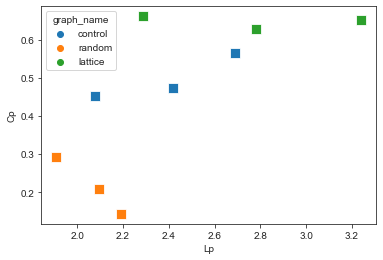

In [6]:
# params
threshold_candidates = [0.2] #, 0.175, 0.15, 0.125, 0.1]

def _calc_swn_features(G):
  """Returns a tuple of (C,L) to calculate SWM features."""

  largest_subgraph = max(nx.connected_components(G), key=len)
  largest_subgraph = G.subgraph(largest_subgraph)
  
  C = nx.average_clustering(largest_subgraph)
  L = nx.average_shortest_path_length(largest_subgraph)
  return (C, L)


def calc_connectome_measures(connectome, condition_name: str, threshold):
  bin_conn = (np.abs(connectome) >= threshold).astype('int')
  G = nx.from_numpy_matrix(bin_conn)                    # small-world (task control)
  Gr = nx.smallworld.random_reference(G, niter=100)     # random
  Gl = nx.smallworld.lattice_reference(G, niter=100)    # lattice

  _measures = [
    (condition_name, 'control', threshold, *_calc_swn_features(G)),
    (condition_name, 'random', threshold, *_calc_swn_features(Gr)),
    (condition_name, 'lattice', threshold, *_calc_swn_features(Gl)),
  ]

  return _measures

measures = [] # list of ('condition', 'graph_type', r, Cp, Lp)

for thr in tqdm(threshold_candidates):
  measures.extend(calc_connectome_measures(all_connectome, 'all', thr))
  measures.extend(calc_connectome_measures(avgp_connectome, 'avgp', thr))
  measures.extend(calc_connectome_measures(nvgp_connectome, 'nvgp', thr))


# nx.draw_spring(G, node_size=400)
measures = pd.DataFrame(measures, columns=['condition', 'graph_name','r','Cp','Lp'])


# Figure 7
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=measures, x='Lp', y='Cp', ax=ax, hue='graph_name', marker='s', s=100)
ax.set(xlim=(1,6), ylim=(0,.7), xlabel='characteristic path length', ylabel='clustering coefficient')

# TODO annotate points with their condition name

plt.show()

In [126]:
all_conns = pd.DataFrame(
  all_connectome, columns=regions, index=regions
).reset_index().melt('index')
all_conns.columns = ['source', 'target', 'connectivity']
all_conns.query('source != target')
all_conns['group'] = 'all'
all_conns

,source,target,connectivity,group
0,R IPS,R IPS,1.000000,all
1,L IPS,R IPS,0.603929,all
2,R frontal cortetrue,R IPS,0.311706,all
3,L frontal cortetrue,R IPS,0.234490,all
4,R precuneus,R IPS,0.289648,all
...,...,...,...,...
1516,R ant fusiform,vmPFC,-0.011533,all
1517,L ant fusiform,vmPFC,0.006058,all
1518,R midtemporal,vmPFC,0.026416,all
1519,L midtemporal,vmPFC,0.030183,all


## Cohen (2014), Chapter 31

### Replicating figure 31.11
The effect of threshold choice on the network structure can be illustrated by a plot that
shows the relationship between clustering coefficient ($C$) and the threshold ($\text{thr}$).

In the plot below, gray lines correspond to the regions and the black line represents
the average clustering coefficient across all regions.

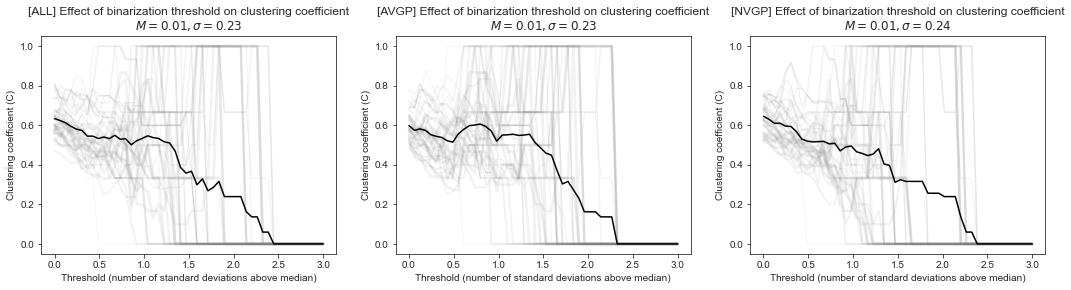

In [11]:

def plot_clustering_coefficient(conn, label, ax=None):

  # collects clustering coefficients for each threshold; format: ('node','threshold_std','r','C')
  C = []

  for x in np.linspace(0.0, 3.0, 50):

    threshold = np.median(conn) + x * np.std(conn)

    # binarize and create graph
    bin_conn = np.abs(conn >= threshold).astype('int')
    Gp = nx.from_numpy_matrix(bin_conn)
    
    for i, _ in enumerate(regions):
      Ci = nx.average_clustering(Gp, nodes=[i])
      C.append((regions[i], x, threshold , Ci))

  plot_data = pd.DataFrame(C, columns=['node', 'threshold_std', 'threshold', 'C'])

  if ax is None:
    _, ax = plt.subplots(1,1)

  # average clustering coefficient across all nodes
  C_avg = plot_data.groupby('threshold_std')['C'].mean()

  # plot average clustering coefficients of the nodes
  sns.lineplot(
    data=plot_data,
    x='threshold_std', y='C',
    size='node', alpha=.1, color='gray',
    ax=ax, legend=False)

  # aggregated coefficient across all nodes
  sns.lineplot(
    x=plot_data['threshold_std'].unique(),
    y=C_avg,
    alpha=1, color='black',
    ax=ax)

  ax.set(
    xlabel='Threshold (number of standard deviations above median)',
    ylabel='Clustering coefficient (C)',
    title=f'[{label.upper()}] Effect of binarization threshold on clustering coefficient\n'
          f'$M={np.median(conn):.2f}, \sigma={np.std(conn):.2f}$')


fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(18,4))

plot_clustering_coefficient(all_connectome, label='all', ax=ax1)
plot_clustering_coefficient(avgp_connectome, label='avgp', ax=ax2)
plot_clustering_coefficient(nvgp_connectome, label='nvgp', ax=ax3)

plt.show()

### Cohen2014: Replicating figure 31.14

In [12]:
# vmPFC is not connected to any other nodes, so it is not included in the analysis
vmPFC_idx = regions.index('vmPFC')
regions_no_vmPFC = np.delete(regions, vmPFC_idx)
conn_no_vmPFC = np.delete(all_connectome, vmPFC_idx, axis=0)
conn_no_vmPFC = np.delete(conn_no_vmPFC, vmPFC_idx, axis=1)

threshold = np.median(conn_no_vmPFC) + np.std(conn_no_vmPFC)
bin_conn = (np.abs(conn_no_vmPFC) >= threshold).astype('int')
G = nx.from_numpy_matrix(bin_conn)  # small-world (task control)

swns = []

max_rewires = 10
for n_rewires in tqdm(range(max_rewires), desc='Rewiring the network'):
  swns.append((n_rewires, nx.smallworld.sigma(G, niter=n_rewires, nrand=10)))

plot_data = pd.DataFrame(swns, columns=['n_rewires','Cr/C','Lr/L'])
plot_data = plot_data.melt(id_vars=['n_rewires'], var_name="swn_measure", value_name="value")

sns.lineplot(data=plot_data, x='n_rewires', y='value', hue='swn_measure')
plt.show()

Rewiring the network: 100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


[1.0000000000000002,
 3.0613273851358596,
 2.916561293381805,
 2.817387075859088,
 3.1580663462007705,
 2.7310682467641625,
 2.8992547767131724,
 2.777539442403285,
 2.804906453052384,
 2.8870230290805172]

### Cohen2014: Replicating permutation testing (figure 31.16)

- threshold as X, and Z-scored small-world-ness as Y
- test the statistical significance of the small-world-ness of the network using permutations.

calculating observed SWN...
observed SWN=3.21
Now simulating random networks...


simulating random networks: 100%|██████████| 100/100 [18:29<00:00, 11.09s/it]


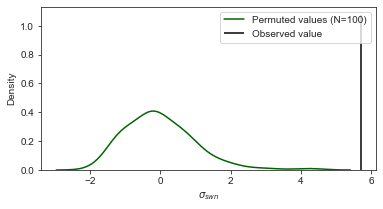

In [44]:
# parameters
n_simulations = 100
threshold = np.median(conn_no_vmPFC) + np.std(conn_no_vmPFC)

def permute_swn(G, n_simulations=10):
  """simulates random network SWM for n times."""
  _sigmas = []
  for _ in tqdm(range(n_simulations), desc='simulating random networks'):
    # step 1:
    Gr = nx.smallworld.random_reference(G, niter=100)
    # step 2:
    # Gr is already randomized so in calculating Cr and Lr we don't need to do randomize
    sigma = nx.smallworld.sigma(Gr, niter=1, nrand=1) # must be > 1 for SW
    # omega = nx.smallworld.omega(g) # must be close to 0 for SW

    _sigmas.append(sigma)
  return _sigmas


# make a binary graph
bin_conn = (np.abs(conn_no_vmPFC) >= threshold).astype('int')
G = nx.from_numpy_matrix(bin_conn)


# observed SWM
print('calculating observed SWN...')
observed_swn = nx.smallworld.sigma(G, niter=100, nrand=10)
print(f'observed SWN={observed_swn:.2f}')

# permuted SWM distribution
print('Now simulating random networks...')
simulated_swns = permute_swn(G, n_simulations)


# PLOT
fig, ax = plt.subplots(figsize=(6,3))

simulated_swns_avg = np.mean(simulated_swns)
simulated_swns_std = np.std(simulated_swns)

simulated_swn_zscores = (np.array(simulated_swns) - simulated_swns_avg) / simulated_swns_std

sns.kdeplot(simulated_swn_zscores, ax=ax, color='darkgreen')

_observed_swn_norm = (observed_swn - simulated_swns_avg) / simulated_swns_std

ax.vlines(
  _observed_swn_norm,
  ymin=0,ymax=1.0,
  color='black')

ax.set(xlabel='$\sigma_{\t{swn}}$')

plt.legend([f'Permuted values (N={n_simulations})','Observed value'])
plt.show()